In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import cross_val_predict
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import seaborn as sns

In [68]:
df = pd.read_csv('CarPrice_Assignment.csv')

# this allows us to see all the columns
pd.set_option('display.max_columns', None)
df


,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,carlength,carwidth,carheight,curbweight,enginetype,cylindernumber,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,1,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,2,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,3,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,94.5,171.2,65.5,52.4,2823,ohcv,six,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,4,2,audi 100 ls,gas,std,four,sedan,fwd,front,99.8,176.6,66.2,54.3,2337,ohc,four,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,5,2,audi 100ls,gas,std,four,sedan,4wd,front,99.4,176.6,66.4,54.3,2824,ohc,five,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200,201,-1,volvo 145e (sw),gas,std,four,sedan,rwd,front,109.1,188.8,68.9,55.5,2952,ohc,four,141,mpfi,3.78,3.15,9.5,114,5400,23,28,16845.0
201,202,-1,volvo 144ea,gas,turbo,four,sedan,rwd,front,109.1,188.8,68.8,55.5,3049,ohc,four,141,mpfi,3.78,3.15,8.7,160,5300,19,25,19045.0
202,203,-1,volvo 244dl,gas,std,four,sedan,rwd,front,109.1,188.8,68.9,55.5,3012,ohcv,six,173,mpfi,3.58,2.87,8.8,134,5500,18,23,21485.0
203,204,-1,volvo 246,diesel,turbo,four,sedan,rwd,front,109.1,188.8,68.9,55.5,3217,ohc,six,145,idi,3.01,3.40,23.0,106,4800,26,27,22470.0


In [69]:
# drop the ID column which will confuse the model
df = df.drop('car_ID', axis=1)


__The red boxes near some features are of no significance.__


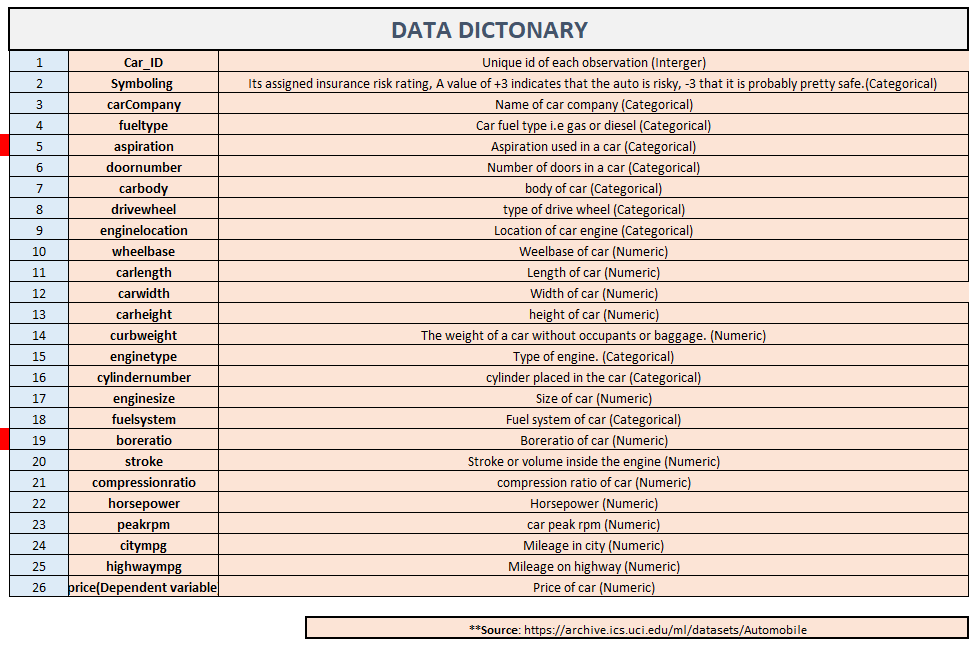

# Things to consider:

1) When eyeballing the dataset I discovered that some columns are really numeric but for some reason had the numbers written as text. This can be fixed by manually changing them to numbers or by using one_hot_encoding. It is probably better to change to numbers since the values have order and aren't simply different categories as would be the case if we used one hot encoding.

2) The name column which has 147 different values so using encoding would give us an enormous amount of features so we will apply basic categories of luxury, midsize, compact car etc..., in place of the names.

3) Normalize df if necesarry.

In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   symboling         205 non-null    int64  
 1   CarName           205 non-null    object 
 2   fueltype          205 non-null    object 
 3   aspiration        205 non-null    object 
 4   doornumber        205 non-null    object 
 5   carbody           205 non-null    object 
 6   drivewheel        205 non-null    object 
 7   enginelocation    205 non-null    object 
 8   wheelbase         205 non-null    float64
 9   carlength         205 non-null    float64
 10  carwidth          205 non-null    float64
 11  carheight         205 non-null    float64
 12  curbweight        205 non-null    int64  
 13  enginetype        205 non-null    object 
 14  cylindernumber    205 non-null    object 
 15  enginesize        205 non-null    int64  
 16  fuelsystem        205 non-null    object 
 1

__Get unique values of columns that label numbers as words. These will be changed to numeric values using a map function__

In [71]:
door_num = df['doornumber'].unique()
cylndr_num = df['cylindernumber'].unique()
print(door_num, '\n', cylndr_num)

['two' 'four'] 
 ['four' 'six' 'five' 'three' 'twelve' 'two' 'eight']


__Once values are known, create dict with those values to use with map__

In [72]:
# in pandas the map works even without a function applied to each value.
door_cylinder_dict = {'two': 2, 'three': 3, 'four': 4, 'five': 5, 'six': 6, 'eight': 8, 'twelve': 12}
df['doornumber'] = df['doornumber'].map(door_cylinder_dict)
df['cylindernumber'] = df['cylindernumber'].map(door_cylinder_dict)
df

,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,carlength,carwidth,carheight,curbweight,enginetype,cylindernumber,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,3,alfa-romero giulia,gas,std,2,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,4,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,3,alfa-romero stelvio,gas,std,2,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,4,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,1,alfa-romero Quadrifoglio,gas,std,2,hatchback,rwd,front,94.5,171.2,65.5,52.4,2823,ohcv,6,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,2,audi 100 ls,gas,std,4,sedan,fwd,front,99.8,176.6,66.2,54.3,2337,ohc,4,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,2,audi 100ls,gas,std,4,sedan,4wd,front,99.4,176.6,66.4,54.3,2824,ohc,5,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200,-1,volvo 145e (sw),gas,std,4,sedan,rwd,front,109.1,188.8,68.9,55.5,2952,ohc,4,141,mpfi,3.78,3.15,9.5,114,5400,23,28,16845.0
201,-1,volvo 144ea,gas,turbo,4,sedan,rwd,front,109.1,188.8,68.8,55.5,3049,ohc,4,141,mpfi,3.78,3.15,8.7,160,5300,19,25,19045.0
202,-1,volvo 244dl,gas,std,4,sedan,rwd,front,109.1,188.8,68.9,55.5,3012,ohcv,6,173,mpfi,3.58,2.87,8.8,134,5500,18,23,21485.0
203,-1,volvo 246,diesel,turbo,4,sedan,rwd,front,109.1,188.8,68.9,55.5,3217,ohc,6,145,idi,3.01,3.40,23.0,106,4800,26,27,22470.0


__Drive Wheel column has four wheel drive as 'fwd' and '4wd'. We will change those to one value__

In [73]:

drive_dict = {'rwd': 'rwd', 'fwd': 'fwd', '4wd': 'fwd'}
df['drivewheel'] = df['drivewheel'].map(drive_dict)
df['drivewheel'].unique()

array(['rwd', 'fwd'], dtype=object)

__Modify the df by removing the CarName column which has too many unique values to use with one_hot_encoding and assign general ratings in place of make and model.__

In [74]:
# the apply function is similar to map, but is used for a pandas column. The [0] is to stop after the first occurence of the delimiter (here a space, which is after
# the company name since that is what we will be using for the rating.)
df['C'] = df['CarName'].apply(lambda x: x.split(' ')[0])

# get unique names as keys for a dict to store rating for each company
companies = df['C'].unique()

# start with an empty value for each key (company)
rating_dict = {}
for i in companies:
  rating_dict[i] = None

# lists for ratings
lux = ['jaguar', 'porsche', 'porcshce', 'audi', 'alfa-romero', 'volvo', 'bmw']
# spelling mistakes and doubles are the way the data was entered
mid = ['chevrolet', 'saab', 'dodge', 'toyota', 'toyouta', 'volkswagen', 'vokswagen', 'vw', 'maxda', 'mazda', 'honda', 'Nissan', 'nissan', 'buick', 'subaru']
# the remaining names are economy

for i in rating_dict:
  if i in lux:
    rating_dict[i] = 4    
  elif i in mid:
    rating_dict[i] = 2 
  else:
    rating_dict[i] = 1   

df['Class'] = df['C'].map(rating_dict)
df = df.drop(['CarName', 'C'], axis=1)
df

,symboling,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,carlength,carwidth,carheight,curbweight,enginetype,cylindernumber,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price,Class
0,3,gas,std,2,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,4,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0,4
1,3,gas,std,2,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,4,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0,4
2,1,gas,std,2,hatchback,rwd,front,94.5,171.2,65.5,52.4,2823,ohcv,6,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0,4
3,2,gas,std,4,sedan,fwd,front,99.8,176.6,66.2,54.3,2337,ohc,4,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0,4
4,2,gas,std,4,sedan,fwd,front,99.4,176.6,66.4,54.3,2824,ohc,5,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200,-1,gas,std,4,sedan,rwd,front,109.1,188.8,68.9,55.5,2952,ohc,4,141,mpfi,3.78,3.15,9.5,114,5400,23,28,16845.0,4
201,-1,gas,turbo,4,sedan,rwd,front,109.1,188.8,68.8,55.5,3049,ohc,4,141,mpfi,3.78,3.15,8.7,160,5300,19,25,19045.0,4
202,-1,gas,std,4,sedan,rwd,front,109.1,188.8,68.9,55.5,3012,ohcv,6,173,mpfi,3.58,2.87,8.8,134,5500,18,23,21485.0,4
203,-1,diesel,turbo,4,sedan,rwd,front,109.1,188.8,68.9,55.5,3217,ohc,6,145,idi,3.01,3.40,23.0,106,4800,26,27,22470.0,4


In [75]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   symboling         205 non-null    int64  
 1   fueltype          205 non-null    object 
 2   aspiration        205 non-null    object 
 3   doornumber        205 non-null    int64  
 4   carbody           205 non-null    object 
 5   drivewheel        205 non-null    object 
 6   enginelocation    205 non-null    object 
 7   wheelbase         205 non-null    float64
 8   carlength         205 non-null    float64
 9   carwidth          205 non-null    float64
 10  carheight         205 non-null    float64
 11  curbweight        205 non-null    int64  
 12  enginetype        205 non-null    object 
 13  cylindernumber    205 non-null    int64  
 14  enginesize        205 non-null    int64  
 15  fuelsystem        205 non-null    object 
 16  boreratio         205 non-null    float64
 1

## __Encoding__

__Encode the dataset with Boolean (dummy) values.__

In [76]:
for col in df.columns:
    
# if the column is not numeric (integer or float)
    if df[col].dtype == 'object':
        df = pd.get_dummies(df, columns=[col], prefix='is')

### __We will transform the data with scaling to get a feel for which features are closely correlated with 'price'.__ 

__Two notes of caution:__

__1:__ We are naming this __df_encoded__ to differentiate between the original df. This is becuase df_encoded is scaled completely meaning every row of the dataset is scaled. This can cause a problem known as __data leakage__ which occurs when running a model on a dataset and the test data has already been scaled to the training data. This effectively gives the model a sneak preview of the test data which makes the scoring of the model a lot less reliable to extrapolate to how the model will perform on other data. 

(One can wonder that maybe on the contrary every time we run the model we should retrain it with the test data, however, in a real-world scenario, you won’t have access to future data when you’re training your model. The goal is to build a model that can make accurate predictions on future data based on the patterns it learned from the past data (training set). If you constantly retrain your model with the test data, you’re assuming that you’ll always have access to future data when making predictions, which is not the case.) Therefore we will use the original __df__ when running the models.

__2:__ The heatmaps show correlation but not causation so it isn't a certainty that the results are entirely accurate. So we will try to run the models at first with the features which seem closely correlated and then with all features.

In [77]:
scaler = MinMaxScaler() 

# in pandas the copy function is like a DEEP COPY and changes made to the copy will not affect the original       
df_encoded = df.copy()
for col in df_encoded.columns:
    
# we will exclude the columns that are dummies since once they were transformed to True and False they are equivalent to 0 and 1, so they will be considered
# like an int.
     if col[:2] != 'is':
        df_encoded[col] = scaler.fit_transform(df_encoded[[col]])

df_encoded

,symboling,doornumber,wheelbase,carlength,carwidth,carheight,curbweight,cylindernumber,enginesize,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price,Class,is_diesel,is_gas,is_std,is_turbo,is_convertible,is_hardtop,is_hatchback,is_sedan,is_wagon,is_fwd,is_rwd,is_front,is_rear,is_dohc,is_dohcv,is_l,is_ohc,is_ohcf,is_ohcv,is_rotor,is_1bbl,is_2bbl,is_4bbl,is_idi,is_mfi,is_mpfi,is_spdi,is_spfi
0,1.0,0.0,0.058309,0.413433,0.316667,0.083333,0.411171,0.2,0.260377,0.664286,0.290476,0.12500,0.262500,0.346939,0.222222,0.289474,0.207959,1.0,False,True,True,False,True,False,False,False,False,False,True,True,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False
1,1.0,0.0,0.058309,0.413433,0.316667,0.083333,0.411171,0.2,0.260377,0.664286,0.290476,0.12500,0.262500,0.346939,0.222222,0.289474,0.282558,1.0,False,True,True,False,True,False,False,False,False,False,True,True,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False
2,0.6,0.0,0.230321,0.449254,0.433333,0.383333,0.517843,0.4,0.343396,0.100000,0.666667,0.12500,0.441667,0.346939,0.166667,0.263158,0.282558,1.0,False,True,True,False,False,False,True,False,False,False,True,True,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False
3,0.8,1.0,0.384840,0.529851,0.491667,0.541667,0.329325,0.2,0.181132,0.464286,0.633333,0.18750,0.225000,0.551020,0.305556,0.368421,0.219254,1.0,False,True,True,False,False,False,False,True,False,True,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False
4,0.8,1.0,0.373178,0.529851,0.508333,0.541667,0.518231,0.3,0.283019,0.464286,0.633333,0.06250,0.279167,0.551020,0.138889,0.157895,0.306142,1.0,False,True,True,False,False,False,False,True,False,True,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200,0.2,1.0,0.655977,0.711940,0.716667,0.641667,0.567882,0.2,0.301887,0.885714,0.514286,0.15625,0.275000,0.510204,0.277778,0.315789,0.291123,1.0,False,True,True,False,False,False,False,True,False,False,True,True,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False
201,0.2,1.0,0.655977,0.711940,0.708333,0.641667,0.605508,0.2,0.301887,0.885714,0.514286,0.10625,0.466667,0.469388,0.166667,0.236842,0.345738,1.0,False,True,False,True,False,False,False,True,False,False,True,True,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False
202,0.2,1.0,0.655977,0.711940,0.716667,0.641667,0.591156,0.4,0.422642,0.742857,0.380952,0.11250,0.358333,0.551020,0.138889,0.184211,0.406311,1.0,False,True,True,False,False,False,False,True,False,False,True,True,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False
203,0.2,1.0,0.655977,0.711940,0.716667,0.641667,0.670675,0.4,0.316981,0.335714,0.633333,1.00000,0.241667,0.265306,0.361111,0.289474,0.430763,1.0,True,False,False,True,False,False,False,True,False,False,True,True,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False


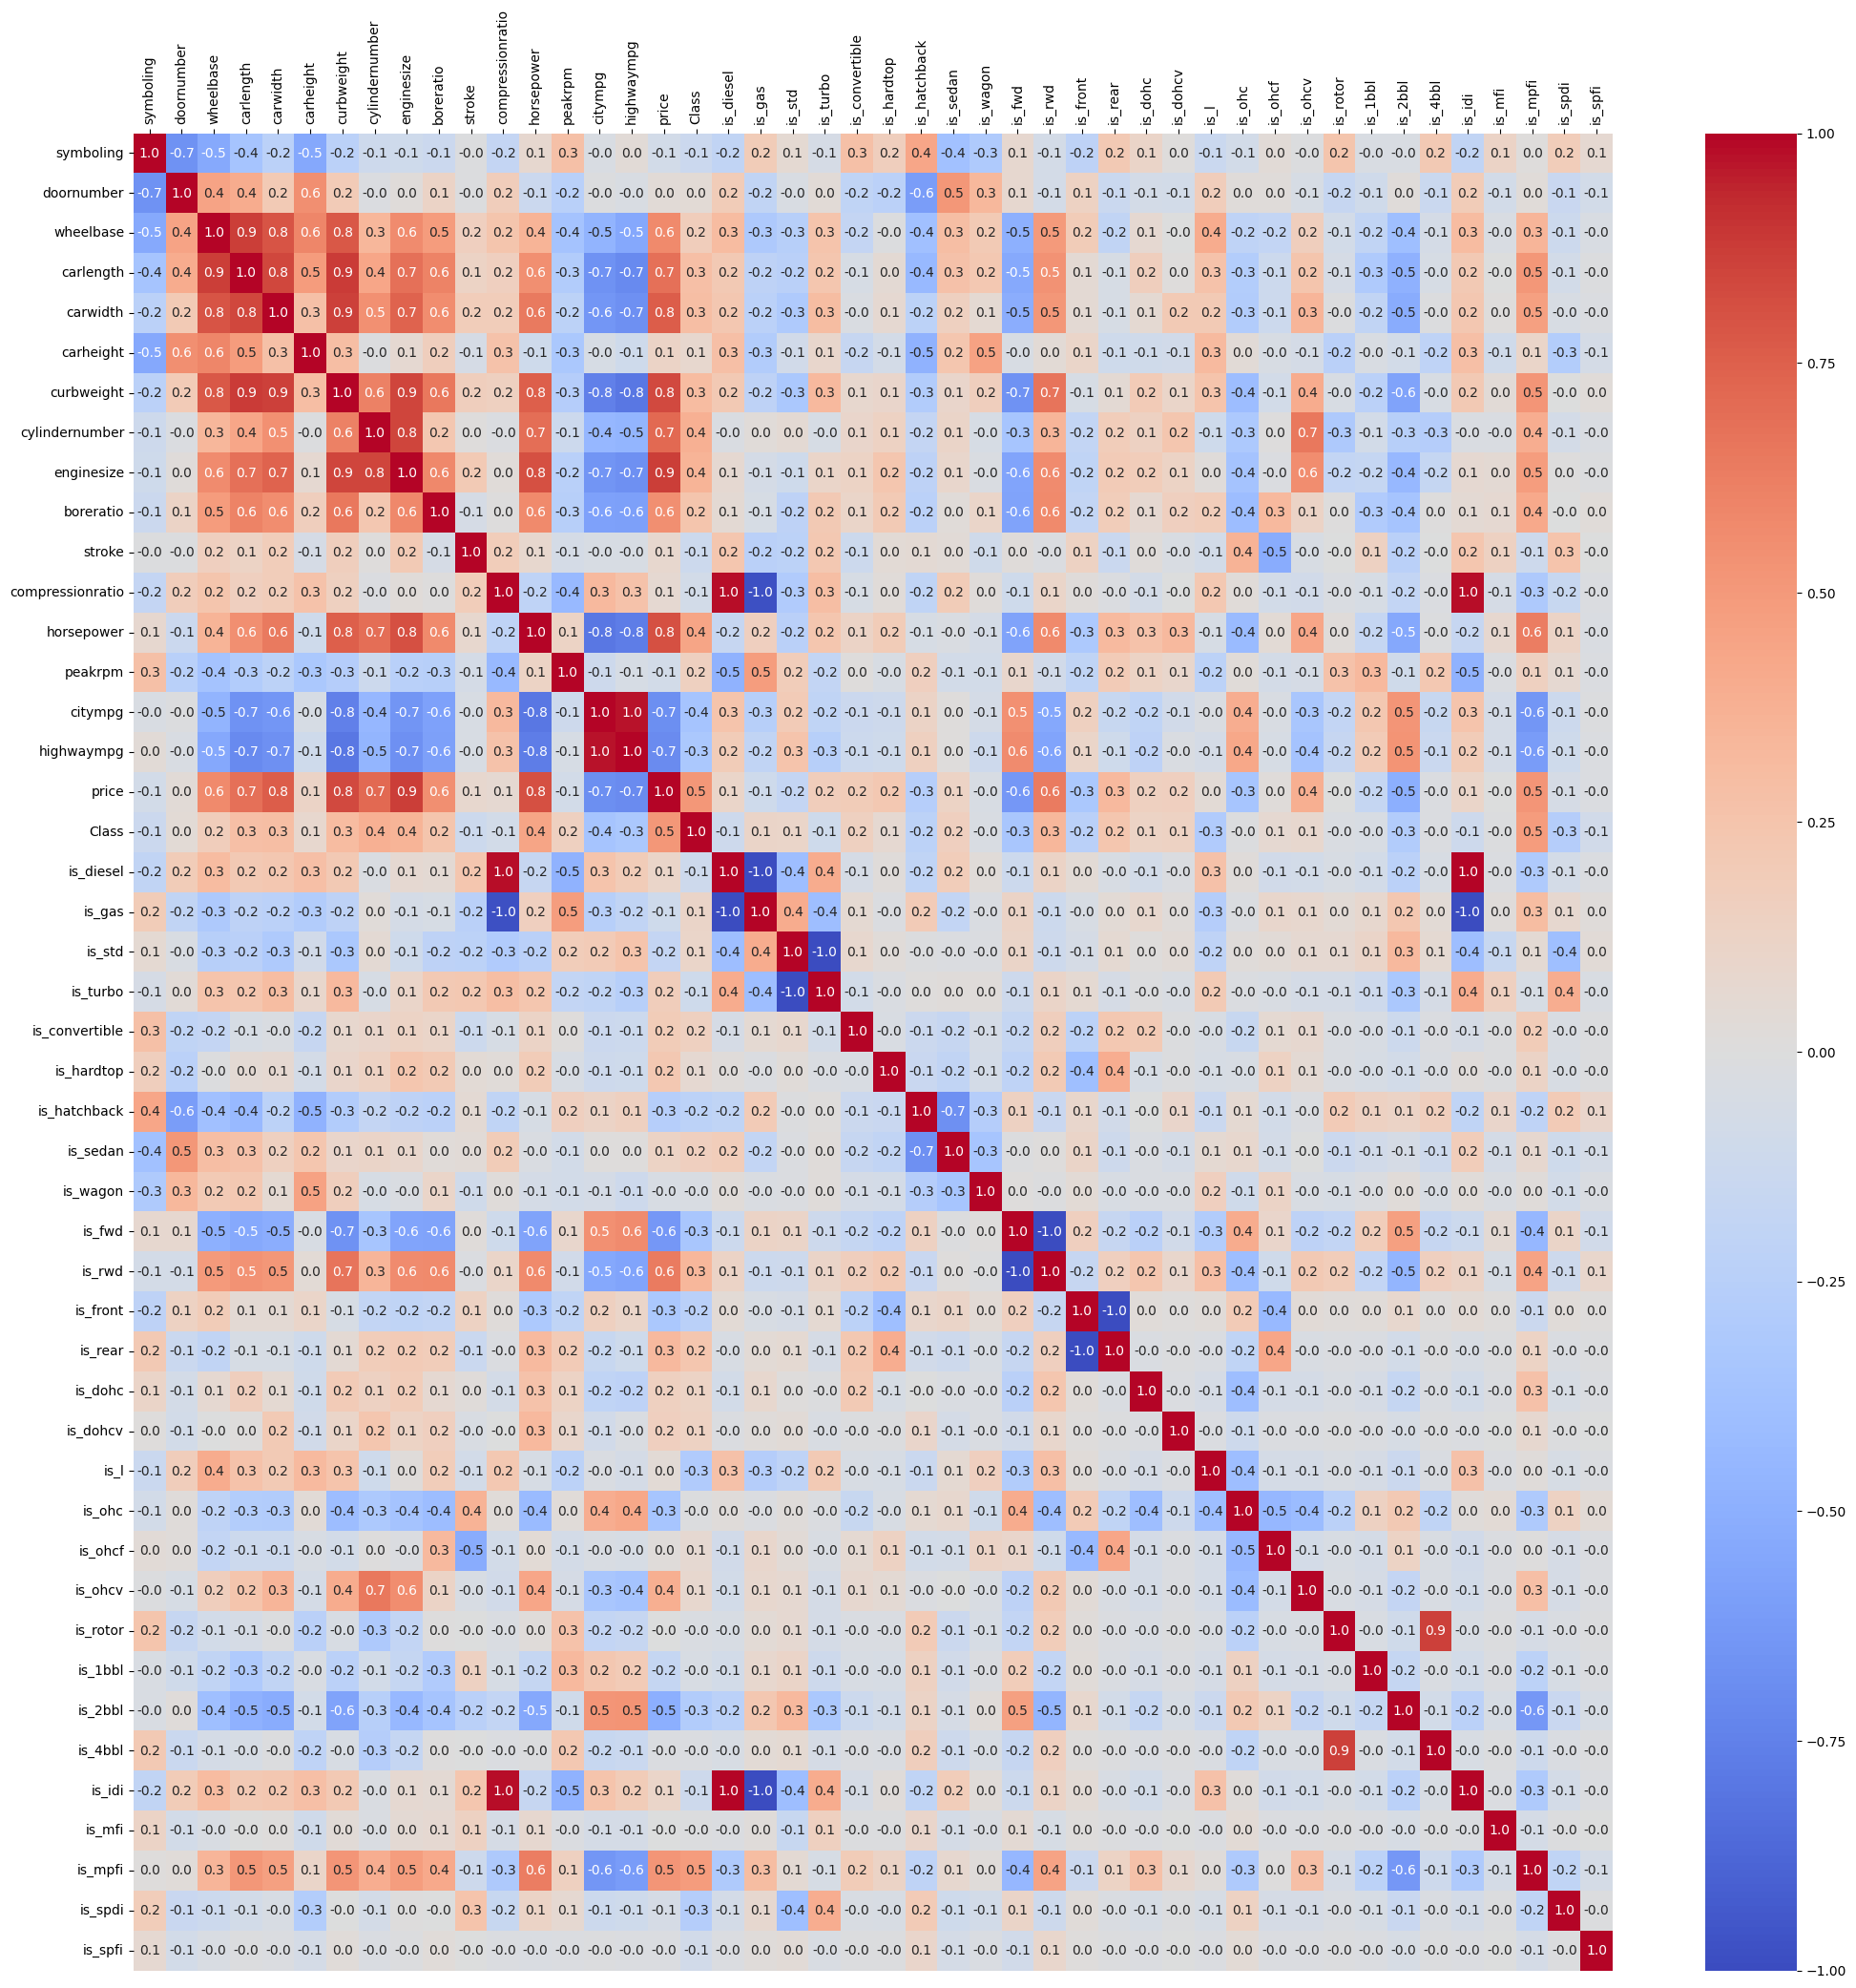

In [78]:
correlation_matrix = df_encoded.corr()

# You can adjust the size as needed. A large size is neede to see this heatmap.
plt.figure(figsize=(25, 25))  
sns.heatmap(correlation_matrix, annot=True, fmt=".1f", cmap='coolwarm')

# move x-axis labels to top
plt.gca().xaxis.tick_top()

# rotate x-axis labels for readability  
plt.xticks(rotation=90)  
plt.show()

## __Creating heatmaps of squared and cubed values__

Perhaps the correlation will be differnt when squared or cubed.

We are not including the True/False columns since they will be unaffected by the squaring and cubing.

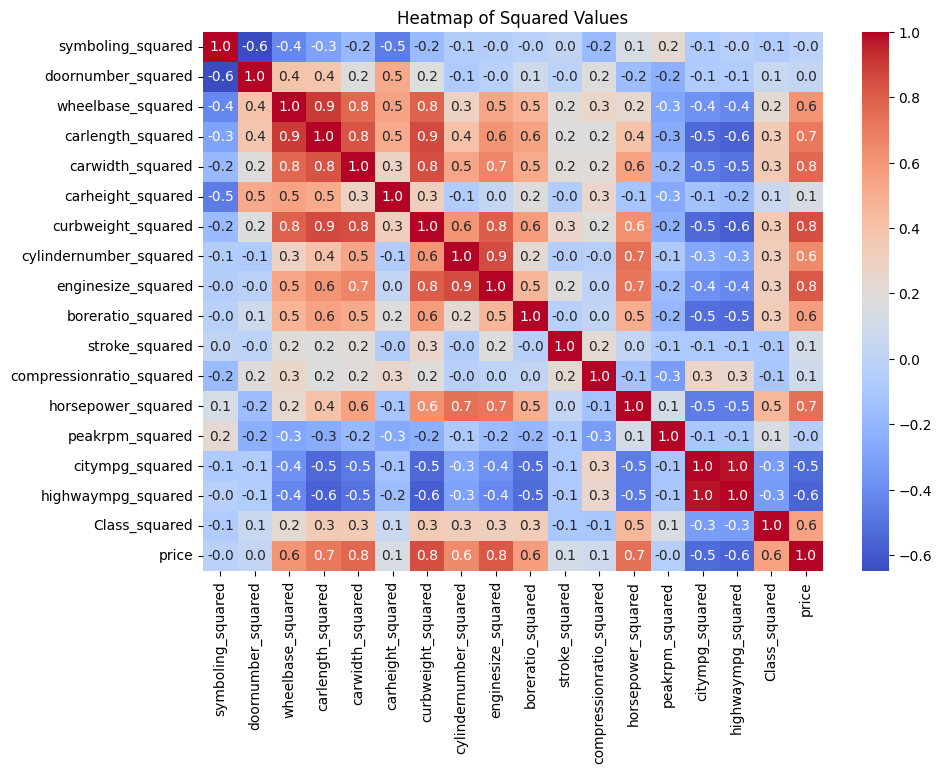

In [79]:
# Create new DataFrames for squared and cubed values
df_squared = pd.DataFrame()
df_cubed = pd.DataFrame()

for col in df.columns:
    if col[:2] != 'is' and col != 'price':
        df_squared[col + '_squared'] = df_encoded[col] ** 2
        df_cubed[col + '_cubed'] = df_encoded[col] ** 3

# Add the target value to the new DataFrames
df_squared['price'] = df['price']
df_cubed['price'] = df['price']

# Now create heatmaps
plt.figure(figsize=(10, 7))
sns.heatmap(df_squared.corr(), annot=True, fmt=".1f", cmap='coolwarm')
plt.title('Heatmap of Squared Values')
plt.xticks(rotation=90)
plt.show()




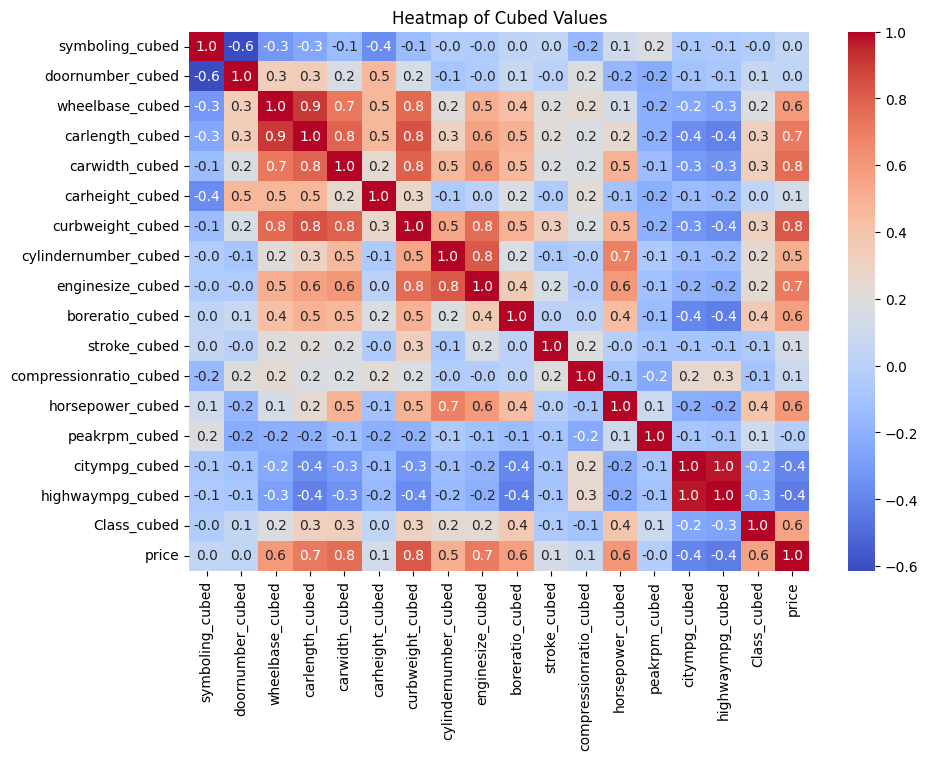

In [80]:
plt.figure(figsize=(10, 7))
sns.heatmap(df_cubed.corr(), annot=True, fmt=".1f", cmap='coolwarm')
plt.title('Heatmap of Cubed Values')
plt.xticks(rotation=90)
plt.show()

### Get the columns that are more closely correlated with price



In [81]:
# Calculate correlation matrices
correlation_matrix = df_encoded.corr()
corr_squared = df_squared.corr()
corr_cubed = df_cubed.corr()

# Get 'price' correlations
price_corr = correlation_matrix['price']
price_corr_squared = corr_squared['price']
price_corr_cubed = corr_cubed['price']

CUTOFF = .60

# assign a correlation score to each column. Average out the columns that has values for squared and cubed as well
# initialize a dictionary to hold the column indexes with the correlations
avg_col_correlations = {}

for i, v  in enumerate(price_corr):
# if the current iteration is smaller than the length of the squred or cubed lists than it contains values that can be averaged
    if i <= len(price_corr_squared) - 1:
        avg_col_correlations[i] = np.mean([price_corr[i], price_corr_squared[i], price_corr_cubed[i]])
    else:
        avg_col_correlations[i] = price_corr[i]
        
# list of indexes of columns that are closer than the cutoff
closely_corr_cols = [corr for corr in avg_col_correlations if abs(avg_col_correlations[corr]) >= CUTOFF]


__We are setting up two dataframes; one with all columns and one with only select cols. We must also use a try and except since every time the cell above is run with the cells below (if we want to change the cutoff) this cell is recalculated which will cause an error since the dataframes no longer have 'price' in them.__

In [82]:
# see above for why we need to use a try and except.
try:
    select_df = df.iloc[:, closely_corr_cols]
    select_df = select_df.loc[:, select_df.columns != 'price']
    y = df['price']
    df = df.loc[:, df.columns != 'price']
except Exception:
    pass

### __Linear regression iterating through both datasets and differnt amounts of folds__ 

In [83]:
# create an instance of linear regression
lin_reg = LinearRegression()

# create a pipeline to be used with cross validation
pipeline = Pipeline([
    ('standardizer', MinMaxScaler()),
    ('regressor', lin_reg)
])

# we will be iterating through both the full dataset and the trimmed dataset with only closely correlated columns
datasets = [df, select_df]

# list of folds for cross validation
folds = list(range(3, 100, 10))

# list to hold to hold best model error metrics
best_reg_model = [0] * 3

# initialize a count variable to use to display the correct dataset name. We could not use the actual names of the datasets in the list since when using the if
# statement an error was encountered since the names of datasets don't have truth values.
count = 1

for j in folds:
    for i in datasets:
        lin_reg_values = cross_val_predict(pipeline, i, y, cv=j)
        lin_reg_R2 = r2_score(y, lin_reg_values)
        lin_reg_rmse = mean_squared_error(y, lin_reg_values, squared=False)
        lin_reg_mae = mean_absolute_error(y, lin_reg_values)
        if count % 2 == 0:
            dataset = 'df_with_select_cols' 
        else:
            dataset = 'full_df'
            
# find best R squared and store the error metrics for that model by comparing each metric with the previous value. We use R_squared as the primary error metric
        if lin_reg_R2 > best_reg_model[0]: 
            best_reg_model[0] = lin_reg_R2
            best_reg_model[1] = lin_reg_rmse
            best_reg_model[2] = lin_reg_mae
            
        print(f"Dataset: {dataset} ---- Folds: {j}")
        print(f"R_squared: {lin_reg_R2: .2f}  RMSE: {lin_reg_rmse: .0f} MAE: {lin_reg_mae: .0f}")
        print('')
        count += 1
print(f"BEST REG MODEL {best_reg_model}")

Dataset: full_df ---- Folds: 3
R_squared:  0.60  RMSE:  5053 MAE:  3696

Dataset: df_with_select_cols ---- Folds: 3
R_squared:  0.76  RMSE:  3916 MAE:  2663

Dataset: full_df ---- Folds: 13
R_squared:  0.67  RMSE:  4553 MAE:  3056

Dataset: df_with_select_cols ---- Folds: 13
R_squared:  0.75  RMSE:  4007 MAE:  2677

Dataset: full_df ---- Folds: 23
R_squared:  0.74  RMSE:  4053 MAE:  2801

Dataset: df_with_select_cols ---- Folds: 23
R_squared:  0.79  RMSE:  3691 MAE:  2522

Dataset: full_df ---- Folds: 33
R_squared:  0.79  RMSE:  3666 MAE:  2462

Dataset: df_with_select_cols ---- Folds: 33
R_squared:  0.80  RMSE:  3582 MAE:  2462

Dataset: full_df ---- Folds: 43
R_squared:  0.74  RMSE:  4054 MAE:  2694

Dataset: df_with_select_cols ---- Folds: 43
R_squared:  0.79  RMSE:  3687 MAE:  2468

Dataset: full_df ---- Folds: 53
R_squared:  0.82  RMSE:  3356 MAE:  2267

Dataset: df_with_select_cols ---- Folds: 53
R_squared:  0.81  RMSE:  3493 MAE:  2400

Dataset: full_df ---- Folds: 63
R_squared:

#### __Polynomial regression.__ We will iterate through degrees of polynomial equations, folds for cross validation, and a cutoff point for how closely correlated a column must be to the target (price). We have an acceptable R squared value of .6 as well. For the polynommial approach only the closely correlated dataset had success. The full dataset was useless. __(This cell can take a few minutes to run)__

In [84]:
degrees = [2, 3, 4]
folds = list(range(3, 100, 20))
poly_cutoff = [i/100 for i in range(70, 85, 4)]
rf_reg_values = LinearRegression()
acceptable_R_2 = .6
best_poly_model = [0] * 3

for degree in degrees:
    for j in folds:
        for cutoff in poly_cutoff:
            poly_closely_corr_cols = [corr for corr in avg_col_correlations if abs(avg_col_correlations[corr]) >= cutoff]
            poly_df = df.iloc[:, poly_closely_corr_cols]
            poly_df = poly_df.loc[:, poly_df.columns != 'price']
            pipeline = Pipeline([
                ('standardizer', MinMaxScaler()),
                ('poly', PolynomialFeatures(degree)),
                ('regressor', LinearRegression())
            ])
            poly_reg_values = cross_val_predict(pipeline, poly_df, y, cv=j)
            poly_reg_R2 = r2_score(y, poly_reg_values)
            poly_reg_rmse = mean_squared_error(y, poly_reg_values, squared=False)
            poly_reg_mae = mean_absolute_error(y, poly_reg_values)
            
            # find best R squared and store the error metrics for that model
            if poly_reg_R2 > best_poly_model[0]: 
                best_poly_model[0] = poly_reg_R2
                best_poly_model[1] = poly_reg_rmse
                best_poly_model[2] = poly_reg_mae
                
            if poly_reg_R2 >= acceptable_R_2:
                print(f"Degree: {degree} ---- Cutoff: {cutoff} ---- Folds: {j}")
                print(f"R_squared: {poly_reg_R2: .2f}  RMSE: {poly_reg_rmse: .0f} MAE: {poly_reg_mae: .0f}")
                print('')
            
print(f"BEST POLY MODEL: {best_poly_model}")

Degree: 2 ---- Cutoff: 0.78 ---- Folds: 3
R_squared:  0.66  RMSE:  4651 MAE:  3055

Degree: 2 ---- Cutoff: 0.82 ---- Folds: 3
R_squared:  0.69  RMSE:  4459 MAE:  2877

Degree: 2 ---- Cutoff: 0.74 ---- Folds: 23
R_squared:  0.62  RMSE:  4882 MAE:  3004

Degree: 2 ---- Cutoff: 0.78 ---- Folds: 23
R_squared:  0.64  RMSE:  4786 MAE:  3118

Degree: 2 ---- Cutoff: 0.82 ---- Folds: 23
R_squared:  0.66  RMSE:  4619 MAE:  2854

Degree: 2 ---- Cutoff: 0.74 ---- Folds: 43
R_squared:  0.64  RMSE:  4769 MAE:  2903

Degree: 2 ---- Cutoff: 0.78 ---- Folds: 43
R_squared:  0.68  RMSE:  4529 MAE:  2919

Degree: 2 ---- Cutoff: 0.82 ---- Folds: 43
R_squared:  0.68  RMSE:  4515 MAE:  2770

Degree: 2 ---- Cutoff: 0.74 ---- Folds: 63
R_squared:  0.74  RMSE:  4059 MAE:  2537

Degree: 2 ---- Cutoff: 0.78 ---- Folds: 63
R_squared:  0.73  RMSE:  4139 MAE:  2743

Degree: 2 ---- Cutoff: 0.82 ---- Folds: 63
R_squared:  0.71  RMSE:  4311 MAE:  2650

Degree: 2 ---- Cutoff: 0.74 ---- Folds: 83
R_squared:  0.72  RMSE: 

## __Random Forest Regression.__
 This algorithm can handle the whole dataset. Make sure to add the n_jobs parameter to -1 as this will use multiple cores on your machine and will speed up performance

In [85]:
best_rf_model = [0] * 3

for i in folds:
      rand_forest = RandomForestRegressor(n_estimators=100, n_jobs=-1)
      pipeline = Pipeline([
                ('standardizer', MinMaxScaler()),
                ('regressor', rand_forest)
            ])
      rf_reg_values = cross_val_predict(pipeline, df, y, cv=i)
      rf_reg_R2 = r2_score(y, rf_reg_values)
      rf_reg_rmse = mean_squared_error(y, rf_reg_values, squared=False)
      rf_reg_mae = mean_absolute_error(y, rf_reg_values)
      

      if rf_reg_R2 > best_rf_model[0]: 
                best_rf_model[0] = rf_reg_R2
                best_rf_model[1] = rf_reg_rmse
                best_rf_model[2] = rf_reg_mae
                
      if rf_reg_R2 >= acceptable_R_2:
                print(f"Folds: {i}")
                print(f"R_squared: {rf_reg_R2: .2f}  RMSE: {rf_reg_rmse: .0f} MAE: {rf_reg_mae: .0f}")
                print('')
                
print(f"BEST RANDOM FOREST MODEL: {best_rf_model}")

Folds: 3
R_squared:  0.82  RMSE:  3421 MAE:  2233

Folds: 23
R_squared:  0.74  RMSE:  4032 MAE:  2238

Folds: 43
R_squared:  0.90  RMSE:  2489 MAE:  1677

Folds: 63
R_squared:  0.91  RMSE:  2449 MAE:  1619

Folds: 83
R_squared:  0.91  RMSE:  2325 MAE:  1537

BEST RANDOM FOREST MODEL: [0.9148883604787872, 2324.968242189775, 1537.1857844552842]


## __Gradient Boosting Regression__

In [86]:
best_grb_model = [0] * 3
for i in folds:
      grb = GradientBoostingRegressor()
      pipeline = Pipeline([
                ('standardizer', MinMaxScaler()),
                ('regressor', rand_forest)
            ])
      grb_reg_values = cross_val_predict(pipeline, df, y, cv=i)
      grb_reg_R2 = r2_score(y, grb_reg_values)
      grb_reg_rmse = mean_squared_error(y, grb_reg_values, squared=False)
      grb_reg_mae = mean_absolute_error(y, grb_reg_values)
      

      if grb_reg_R2 > best_grb_model[0]: 
                best_grb_model[0] = grb_reg_R2
                best_grb_model[1] = grb_reg_rmse
                best_grb_model[2] = grb_reg_mae
                
      if rf_reg_R2 >= acceptable_R_2:
                print(f"Folds: {i}")
                print(f"R_squared: {grb_reg_R2: .2f}  RMSE: {grb_reg_rmse: .0f} MAE: {grb_reg_mae: .0f}")
                print('')
                
print(f"BEST GRADIENT BOOST MODEL: {best_grb_model}")

Folds: 3
R_squared:  0.81  RMSE:  3474 MAE:  2257

Folds: 23
R_squared:  0.75  RMSE:  3970 MAE:  2216

Folds: 43
R_squared:  0.90  RMSE:  2515 MAE:  1700

Folds: 63
R_squared:  0.90  RMSE:  2500 MAE:  1663

Folds: 83
R_squared:  0.92  RMSE:  2299 MAE:  1558

BEST GRADIENT BOOST MODEL: [0.9167770060899096, 2299.027755627372, 1558.4423511730547]


In [87]:
# create master list with best models for all regression algorithms
best_models = [best_reg_model, best_poly_model, best_rf_model, best_grb_model]


## __Summary of results and visualazations__

SUMMARY OF RESULTS: 

Linear Regression
R Squared: 0.84    RMSE: $3,228.04 (24% of mean car price)    MAE: $2,198.54 (17% of mean car price) 

Polynomial Regression
R Squared: 0.83    RMSE: $3,322.86 (25% of mean car price)    MAE: $2,221.52 (17% of mean car price) 

Random Forest
R Squared: 0.91    RMSE: $2,324.97 (18% of mean car price)    MAE: $1,537.19 (12% of mean car price) 

Gradient Boost
R Squared: 0.92    RMSE: $2,299.03 (17% of mean car price)    MAE: $1,558.44 (12% of mean car price) 



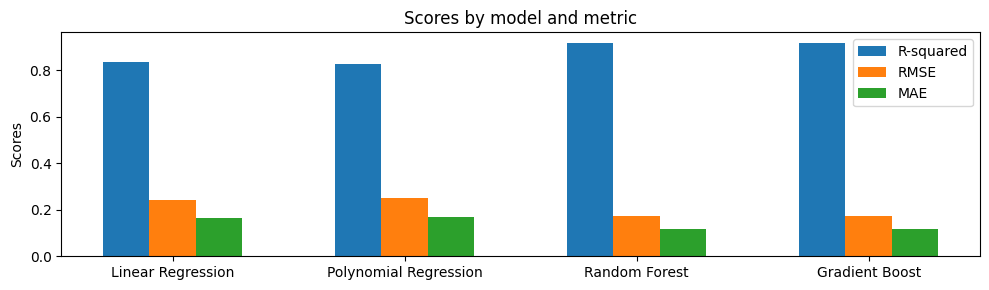

In [90]:

# Create labels for the grouped bar plot
labels = ['Linear Regression', 'Polynomial Regression', 'Random Forest', 'Gradient Boost']

print('SUMMARY OF RESULTS:', '\n')

# format all values in lists to two decimal spaces
formatted_error_metrics = [[round(x, 2) for x in model] for model in best_models]

# display results by outputting actual errors and the errors scaled to the value of 'price'.
for i in range(len(formatted_error_metrics)):
    print(labels[i])
    print(f"R Squared: {formatted_error_metrics[i][0]}", end='    ')
    print(f"RMSE: ${formatted_error_metrics[i][1]:,} ({(formatted_error_metrics[i][1]/y.mean()) * 100:.0f}% of mean car price)", end='    ')
    print(f"MAE: ${formatted_error_metrics[i][2]:,} ({(formatted_error_metrics[i][2]/y.mean()) * 100:.0f}% of mean car price)", '\n')

# get all the R squared, rmse, and mae values in individual lists. Rmse and mae must be scaled to be displayed on the same plot.
r_squared = [model[0] for model in best_models]
rmse = [model[1]/y.mean() for model in best_models]
mae = [model[2]/y.mean() for model in best_models]

# position the bars and labels on the X axis
x = np.arange(len(labels))  
# bar width
width = 0.2  

# create a figure and subplots
fig, ax = plt.subplots(figsize=(10, 3))

# use 'x' to have each group of bars evenly spaced
rects1 = ax.bar(x - width, r_squared, width, label='R-squared')
rects2 = ax.bar(x, rmse, width, label='RMSE')
rects3 = ax.bar(x + width, mae, width, label='MAE')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Scores by model and metric')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()


plt.show()